# Predicting type of breast cancer cells

### Questions of interest:

1. What features of a cell are the largest drivers of malignancy?
2. How would a physician use your produce?
3. There is a non-zero cost in time and money to collect each feature about a given cell. How would you go about determining the most cost-effective method of detecting malignancy?

### Project description.

The dataset contains the following features for each cell:
Sample code number: id number
Clump Thickness: 1 - 10
Uniformity of Cell Size: 1 - 10
Uniformity of Cell Shape: 1 - 10
Marginal Adhesion: 1 - 10
Single Epithelial Cell Size: 1 - 10
Bare Nuclei: 1 - 10
Bland Chromatin: 1 - 10
Normal Nucleoli: 1 - 10
Mitoses: 1 - 10
Class: (2 for benign, 4 for malignant)
My investigation
I'm interested in trying to predict the type of breast cancer cells, while minimizing the number of false negatives (not detecting malignant cancer when actually present).

### Hypotheses

1. There are features of a cell that are the largest drivers of malignancy.
2. Physicians could use less cell features and still get good predictions.

### Findings

1. Cell features that are biggest contributors to the prediction are: Uniformity of Cell Size, Bare Nuclei and Clump Thickness.
2. Based on a dataset, it was possible to build a classifier with high recall, to bias classifier towards reduction of false negatives and still have high accuracy overall.

### Recommendations

1. Even though some features seem more important than the others, only by incuding all features you can get an accurate prediction of the malignancy.

In [280]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [281]:
df = pd.read_csv('breast-cancer-wisconsin.txt')
df.head()

,Index,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,0,1241035,7,8,3,7,4,5,7,8,2,4
1,1,1107684,6,10,5,5,4,10,6,10,1,4
2,2,691628,8,6,4,10,10,1,3,5,1,4
3,3,1226612,7,5,6,3,3,8,7,4,1,4
4,4,1142706,5,10,10,10,6,10,6,5,2,4


In [282]:
df.columns

Index(['Index', 'ID', 'Clump Thickness', 'Uniformity of Cell Size',
       'Uniformity of Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
       'Normal Nucleoli', 'Mitoses', 'Class'],
      dtype='object')

## 2. Exploratory Data Analysis

First I'm checking the dataset for any missing values, duplicates...
There are 28 data rows with missing information. Compared to the dataset size, that is a fairly small number (0.2% of the dataset), so it's safe to drop these columns.

In [283]:
#any null values in the dataset?
df_missing = df[df['Bare Nuclei'].isnull()]
missing_percent = len(df_missing)/len(df)*100
print(missing_percent)

0.17660044150110377


In [284]:
def clean_data(df):
    
    df = df.dropna()
    
    # there are two index columns, just getting rid of one
    df = df.drop(columns = ['Index'])
    
    # dropping duplicates
    df = df.drop_duplicates()
    
    # there are still some duplicates in the set, based on the ID
    id_duplicates = len(df[df['ID'].duplicated()])
    
    # some 'no idea' and special char (#,?) rows
    str_data = len(df[df['ID'].duplicated()])
    
    # remove all non-numeric rows (filtered based on a category that has to be numeric)
    df.loc[:,'non_numeric'] = pd.to_numeric(df['Uniformity of Cell Size'], errors='coerce').isnull()
    df = df[df.non_numeric == False]
    
    # 45 more ID duplicates - possibly multiple visits by a single patient, not touching that for now
    id_duplicates = len(df[df['ID'].duplicated()])
    df = df.drop(['non_numeric'], axis=1)
    
    # values '?' in Bare Nuclei (#total of 16)
    chars_nuclei = len(df[df['Bare Nuclei'] =='?'])
    df["Bare Nuclei"] = df["Bare Nuclei"].replace('?', 11)
    
    # convert all data (chars) to numeric
    df = df.apply(pd.to_numeric)
    
    # some rows are multiplied by 10, scale that back down (class =20,40)
    df[(df.Class == 20) | (df.Class == 40)] = df[(df.Class == 20) | (df.Class == 40)]/10
    
    return df

In [285]:
df = clean_data(df)

<Figure size 2160x720 with 0 Axes>

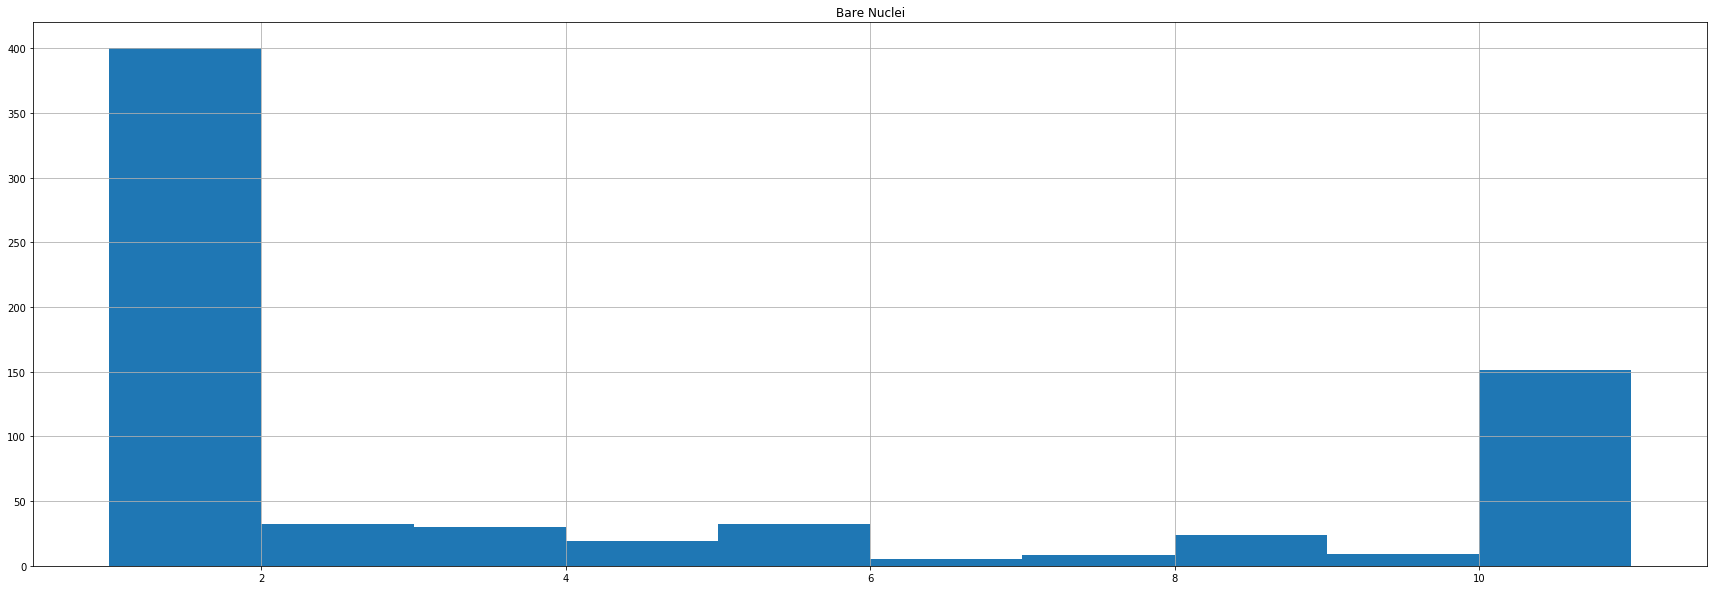

In [286]:
#Histogram of Bare Nuclei distribution... unsure, what is a good replacement category? 
figure = plt.figure()
df.hist(column = 'Bare Nuclei')
plt.show()

# 2. Visualization

Two classes, fairly unbalanced as expected (malignant casses are less common)

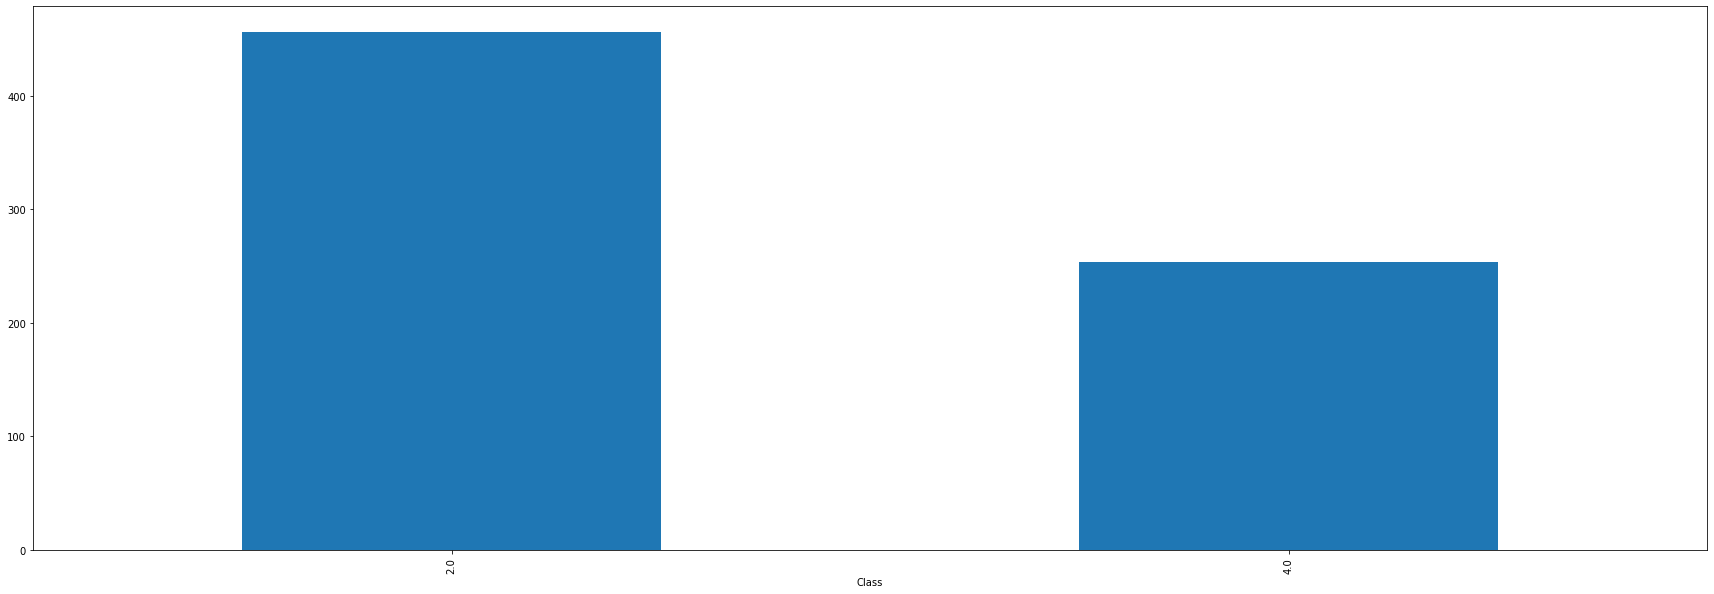

In [287]:
figure = plt.figure()
df.groupby('Class').Class.count().plot.bar(ylim=0)
plt.show()

<Figure size 2160x720 with 0 Axes>

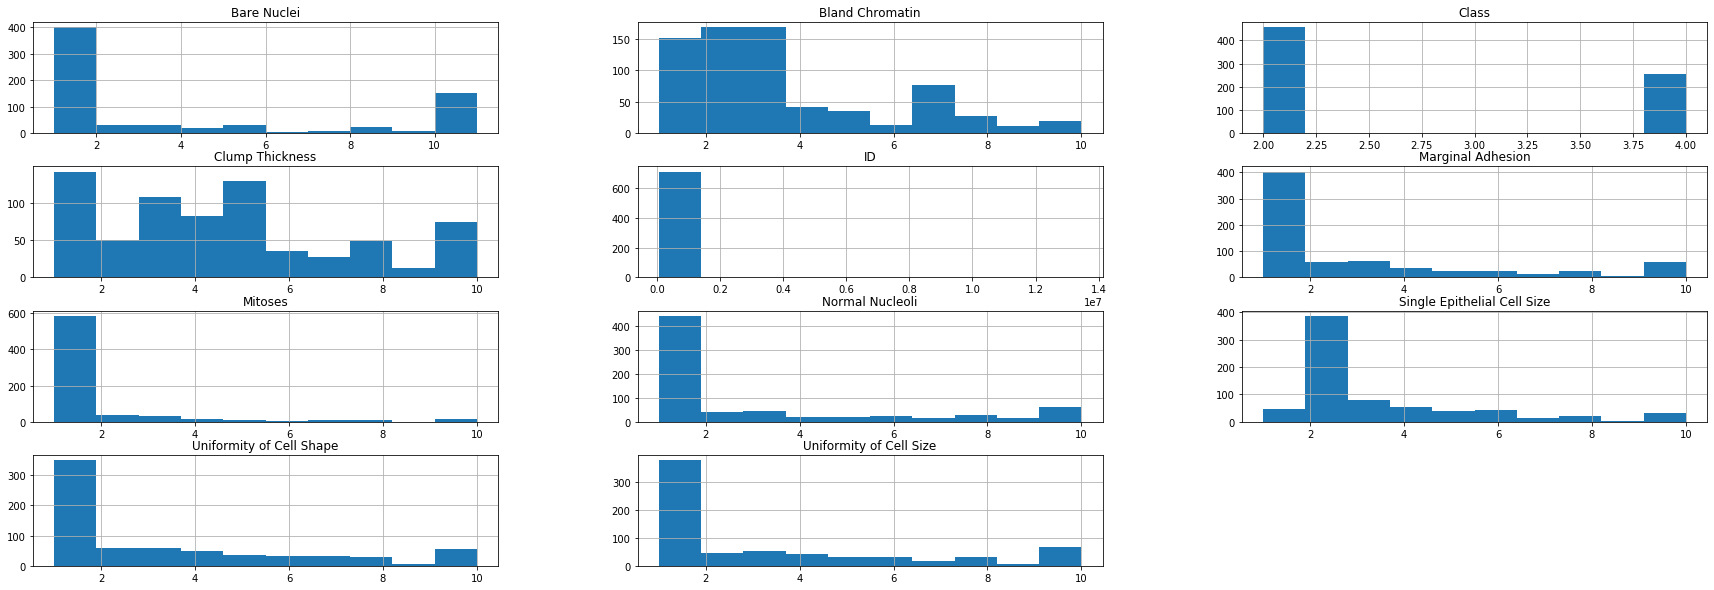

In [288]:
#indiviual features histograms (Clump Thickness, Bland Chromatin most variable)
figure = plt.figure()
df.hist()
plt.rcParams['figure.figsize'] = [30, 10]
plt.show()

## 3. Feature extraction

In [289]:
df.head()

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1241035.0,7.0,8.0,3.0,7.0,4.0,5.0,7.0,8.0,2.0,4.0
1,1107684.0,6.0,10.0,5.0,5.0,4.0,10.0,6.0,10.0,1.0,4.0
2,691628.0,8.0,6.0,4.0,10.0,10.0,1.0,3.0,5.0,1.0,4.0
3,1226612.0,7.0,5.0,6.0,3.0,3.0,8.0,7.0,4.0,1.0,4.0
4,1142706.0,5.0,10.0,10.0,10.0,6.0,10.0,6.0,5.0,2.0,4.0


In [290]:
X_df = df.drop(columns = ['ID','Class'])
y_df = df['Class']
# binarizing y variable
y = [0 if item == 2 else 1 for item in y_df]

In [291]:
# defining input features and output classes
X = X_df.values
y = np.array(y)

In [292]:
# stratified split to make sure both classes are equally represented in training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [293]:
clf = LogisticRegression(solver = 'liblinear')
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [294]:
predictions = clf.predict(X_test)
# score evaluation results
accuracy_score = accuracy_score(y_test, predictions)
print(accuracy_score)
confusion_matrix(y_test, predictions)
#classification_report = metrics.classification_report(y_test, predictions, target_names=id_to_category)

0.9574468085106383


array([[145,   6],
       [  4,  80]])

In [295]:
target_names = ['benign', 'malignant']
print(classification_report(y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

      benign       0.97      0.96      0.97       151
   malignant       0.93      0.95      0.94        84

    accuracy                           0.96       235
   macro avg       0.95      0.96      0.95       235
weighted avg       0.96      0.96      0.96       235



Let's see which features are of highest importance for good prediction.

In [296]:
clf.coef_.T

array([[ 0.26697132],
       [ 0.19988392],
       [ 0.2263129 ],
       [ 0.32499766],
       [-0.0507004 ],
       [ 0.17426551],
       [ 0.23314959],
       [ 0.11624648],
       [ 0.15663247]])

In [297]:
columns = df.columns
np.array([columns[1:-1]]).T

array([['Clump Thickness'],
       ['Uniformity of Cell Size'],
       ['Uniformity of Cell Shape'],
       ['Marginal Adhesion'],
       ['Single Epithelial Cell Size'],
       ['Bare Nuclei'],
       ['Bland Chromatin'],
       ['Normal Nucleoli'],
       ['Mitoses']], dtype=object)

In [298]:
feature_importance=pd.DataFrame(np.hstack((np.array([columns[1:-1]]).T, clf.coef_.T)), columns=['feature', 'importance'])

In [299]:
feature_importance['importance']=pd.to_numeric(feature_importance['importance'])

In [300]:
feature_importance.sort_values(by='importance', ascending=False)

,feature,importance
3,Marginal Adhesion,0.324998
0,Clump Thickness,0.266971
6,Bland Chromatin,0.233150
2,Uniformity of Cell Shape,0.226313
1,Uniformity of Cell Size,0.199884
5,Bare Nuclei,0.174266
8,Mitoses,0.156632
7,Normal Nucleoli,0.116246
4,Single Epithelial Cell Size,-0.050700


Even though there is a high general prediction accuracy, there is a problem where different outcomes come with a different price. For example, predicting False Negatives (FN) should never happen.

In [301]:
fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=2)
print(thresholds)

[2 1 0]


/home/ivana/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [302]:
roc_auc = auc(fpr, tpr)

In order to minimize the amount of False Negatives. For that reason, I need higher recall. I also need to adjust the decision threshold using the precision recall curve and the roc curve.

In [303]:
y_scores = clf.predict_proba(X_test)[:, 1]

In [304]:
def adjusted_classes(y_scores, t):
    #adjusts class predictions based on the prediction threshold (t).
    
    return [1 if y >= t else 0 for y in y_scores]

In [305]:
# generate the precision recall curve
p, r, thresholds = precision_recall_curve(y_test, y_scores)

In [306]:
def precision_recall_threshold(t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

     pred_neg  pred_pos
neg       143         8
pos         0        84


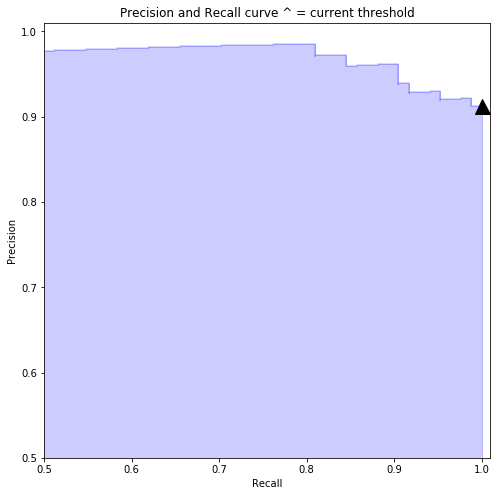

In [314]:
precision_recall_threshold(t=0.24)

In [308]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

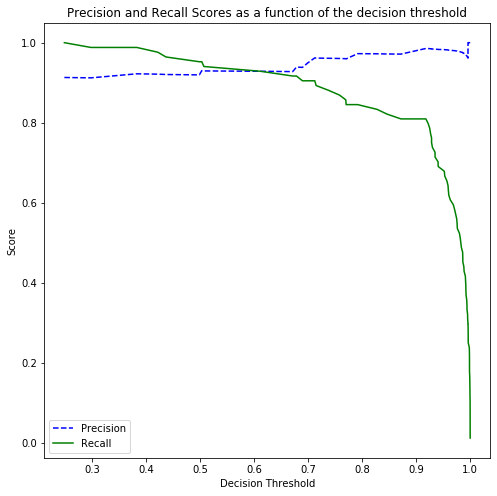

In [309]:
plot_precision_recall_vs_threshold(p,r,thresholds)

In [310]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

0.9908546199936928


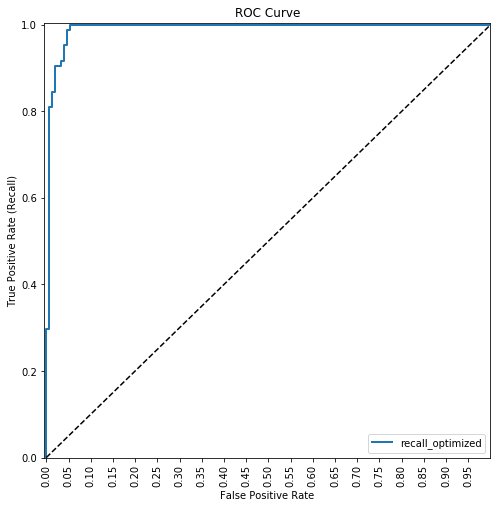

In [311]:
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')